<a href="https://colab.research.google.com/github/poisonkissedsk/Production-Grade-AI-QA-Suite/blob/main/End_to_End_Pipeline_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 6.1 MB/s eta 0:00:00


/tmp/ipython-input-1-2769017049.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric] = StandardScaler().fit_transform(X[numeric])



[INFO] Model Accuracy: 0.8261

[INFO] Selection Rates by Group:
sex  race
0    0       0.000000
     1       0.037037
     2       0.020151
     3       0.066667
     4       0.037709
1    0       0.089286
     1       0.205882
     2       0.092500
     3       0.043478
     4       0.228107
Name: selection_rate, dtype: float64
[INFO] Demographic Parity Difference (Sex): 0.1797


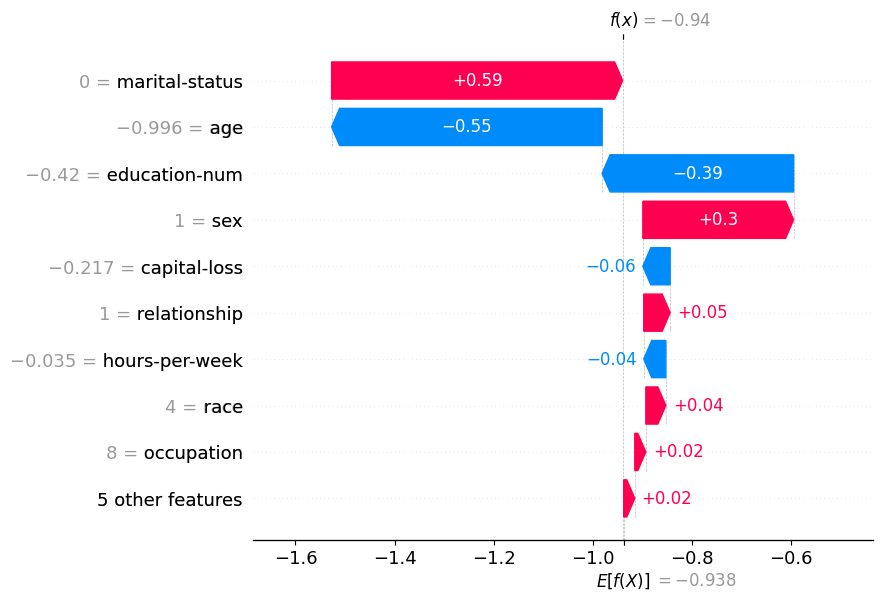


Pipeline Summary:

- Total Candidates Processed: 8141
- Accuracy: 0.8261
- Demographic Parity Difference (Sex): 0.1797
- XAI Snapshot: Visual explanation plotted for candidate #10.

[PIPELINE STATUS: PASS]


In [1]:
# 📒 Notebook 4: End-to-End Pipeline Testing - Screening + Bias Audit + Explainability

# -- SETUP --
!pip install fairlearn shap scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference

# -- STEP 1: Load Data (Simulate Resume Parsing Output) --

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)
df['label'] = (df['income'] == '>50K').astype(int)

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for col in categorical:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df[categorical + numeric]
y = df['label']

X[numeric] = StandardScaler().fit_transform(X[numeric])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# -- STEP 2: Train Screening Model --

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# -- STEP 3: Screening Predictions --
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"\n[INFO] Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# -- STEP 4: Bias Audit (Aggregated) --

sensitive_features = X_test[['sex', 'race']]
metric_frame = MetricFrame(
    metrics={
        'selection_rate': selection_rate,
        'accuracy': accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

print("\n[INFO] Selection Rates by Group:")
print(metric_frame.by_group['selection_rate'])

dpd_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['sex'])
print(f"[INFO] Demographic Parity Difference (Sex): {dpd_sex:.4f}")

# -- STEP 5: XAI (SHAP Explanation Snapshot) --

explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Save single candidate explanation as snapshot
candidate_index = 10
shap.plots.waterfall(shap_values[candidate_index], max_display=10)

# -- STEP 6: Log and Summarize Results --

print("\nPipeline Summary:")
print(f"\n- Total Candidates Processed: {len(X_test)}")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"- Demographic Parity Difference (Sex): {dpd_sex:.4f}")
print("- XAI Snapshot: Visual explanation plotted for candidate #10.")

print("\n[PIPELINE STATUS: PASS]")